<a href="https://colab.research.google.com/github/Braelin2/ECGR5105HW7/blob/main/ECGR5105_HW7_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as torch
import torch.optim as optim
import torch.nn as nn

!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.0 MB/s eta 0:00:00
time: 361 µs (started: 2023-12-13 00:01:25 +00:00)


In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}")

Training on device cpu
time: 16.3 ms (started: 2023-12-13 00:01:29 +00:00)


In [ ]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # <2>


100%|██████████| 170498071/170498071 [00:04<00:00, 42246664.64it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified
time: 24.1 s (started: 2023-12-12 16:36:45 +00:00)


50000


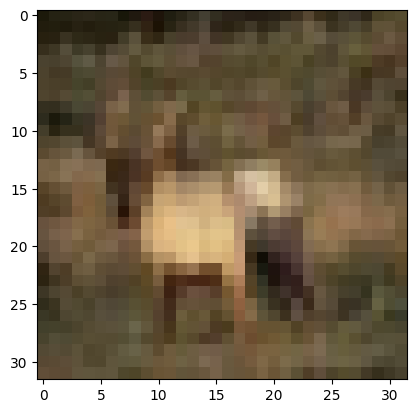

time: 701 ms (started: 2023-12-12 16:37:17 +00:00)


In [ ]:
print(len(cifar10))

img, label = cifar10[3]

plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

cifar10_train_t = datasets.CIFAR10(data_path, train = True, download = False, transform = transforms.ToTensor())
cifar10_test_t = datasets.CIFAR10(data_path, train = False, download = False, transform = transforms.ToTensor())


time: 2.9 s (started: 2023-12-12 16:37:19 +00:00)


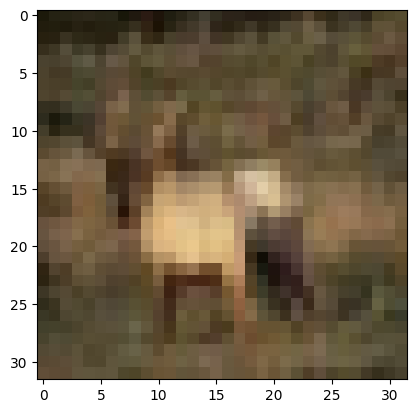

time: 352 ms (started: 2023-12-12 16:37:24 +00:00)


In [ ]:
img_t, _ = cifar10_train_t[3]

plt.imshow(img_t.permute(1,2,0))
plt.show()

In [ ]:
imgs = torch.stack([img_t for img_t, _ in cifar10_train_t], dim = 3)
#imgs.shape

time: 12.6 s (started: 2023-12-12 16:37:27 +00:00)


In [ ]:
imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

time: 94.3 ms (started: 2023-12-12 16:37:42 +00:00)


In [ ]:
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

time: 1.13 s (started: 2023-12-12 16:37:44 +00:00)


In [ ]:
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

time: 4.5 ms (started: 2023-12-12 16:37:46 +00:00)


In [ ]:
transformed_cifar10_train = datasets.CIFAR10(data_path, train = True, download = False,
                                            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

transformed_cifar10_test = datasets.CIFAR10(data_path, train = False, download = False,
                                            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

time: 838 ms (started: 2023-12-12 16:37:51 +00:00)


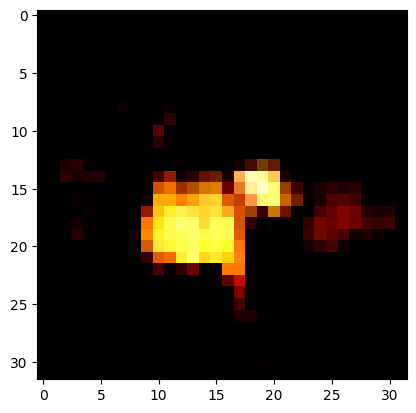

time: 191 ms (started: 2023-12-12 16:37:58 +00:00)


In [ ]:
img_t, _ = transformed_cifar10_train[3]

plt.imshow(img_t.permute(1,2,0))
plt.show()

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device = device)
      labels = labels.to(device = device)

      outputs = model(imgs)

      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training Loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

time: 787 µs (started: 2023-12-12 16:38:03 +00:00)


In [ ]:
import torch.nn.functional as F

class NetRes(nn.Module):
  def __init__(self, n_chans1 = 32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2 , kernel_size = 3, padding = 1)

    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
    out = out.view(-1,4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out


time: 1.35 ms (started: 2023-12-12 16:45:28 +00:00)


In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64, shuffle=True)


model = NetRes().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-12-12 16:45:45.120717 Epoch 1, Training Loss 2.105788602243604
2023-12-12 16:47:52.926419 Epoch 10, Training Loss 1.1231182755716622
2023-12-12 16:50:15.165971 Epoch 20, Training Loss 0.8852256809354133
2023-12-12 16:52:36.343569 Epoch 30, Training Loss 0.7839599685062228
2023-12-12 16:54:58.374186 Epoch 40, Training Loss 0.7216782669734467
2023-12-12 16:57:21.321529 Epoch 50, Training Loss 0.6763337035008403
2023-12-12 16:59:40.968409 Epoch 60, Training Loss 0.6399481967282112
2023-12-12 17:02:01.739195 Epoch 70, Training Loss 0.6075613332526458
2023-12-12 17:04:23.435128 Epoch 80, Training Loss 0.582436959685572
2023-12-12 17:06:48.310581 Epoch 90, Training Loss 0.5590829010052449
2023-12-12 17:09:12.663388 Epoch 100, Training Loss 0.5403062923789939
2023-12-12 17:11:40.634030 Epoch 110, Training Loss 0.5224109741732897
2023-12-12 17:14:10.826032 Epoch 120, Training Loss 0.5073637597624908
2023-12-12 17:16:42.902189 Epoch 130, Training Loss 0.4970909355546507
2023-12-12 17:19:11

In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64,shuffle=False)

test_loader = torch.utils.data.DataLoader(transformed_cifar10_test, batch_size=64, shuffle=False)

correct = 0
total = 0

def validate(model, train_loader, test_loader):
  for name, loader in [("train", train_loader), ("val", test_loader)]:
    correct = 0;
    total = 0;

    with torch.no_grad():
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device = device))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels.to(device = device)).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, test_loader)



Accuracy train: 0.80
Accuracy val: 0.80
time: 26.8 s (started: 2023-12-12 17:59:24 +00:00)


In [ ]:
print(sum([p.numel() for p in model.parameters()]))

16394
time: 1.35 ms (started: 2023-12-12 17:59:56 +00:00)


In [ ]:
#Weight Penalty
def training_loop_Penalty(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device = device)
      labels = labels.to(device = device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      l2_lambda = 0.001
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
      loss = loss + l2_lambda * l2_norm

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training Loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

time: 944 µs (started: 2023-12-12 18:18:08 +00:00)


In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64, shuffle=True)

model = NetRes().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_Penalty(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-12-12 18:19:39.288801 Epoch 1, Training Loss 2.079636944072021
2023-12-12 18:22:06.432310 Epoch 10, Training Loss 1.141007233687374
2023-12-12 18:25:13.501480 Epoch 20, Training Loss 0.9597368613076027
2023-12-12 18:28:14.693368 Epoch 30, Training Loss 0.8832571490493881
2023-12-12 18:31:28.331379 Epoch 40, Training Loss 0.8368857480071085
2023-12-12 18:34:12.207857 Epoch 50, Training Loss 0.8078877842029952
2023-12-12 18:36:45.294893 Epoch 60, Training Loss 0.7835917001413872
2023-12-12 18:39:21.794145 Epoch 70, Training Loss 0.770222819445993
2023-12-12 18:41:59.559727 Epoch 80, Training Loss 0.7548919689015049
2023-12-12 18:44:34.549905 Epoch 90, Training Loss 0.7466213576629034
2023-12-12 18:47:06.912732 Epoch 100, Training Loss 0.7385625243186951
2023-12-12 18:49:39.689837 Epoch 110, Training Loss 0.7320131550130942
2023-12-12 18:52:12.671748 Epoch 120, Training Loss 0.7266498678709234
2023-12-12 18:54:45.622938 Epoch 130, Training Loss 0.7232765333579324
2023-12-12 18:57:17.

In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64,shuffle=False)

test_loader = torch.utils.data.DataLoader(transformed_cifar10_test, batch_size=64, shuffle=False)

correct = 0
total = 0

def validate(model, train_loader, test_loader):
  for name, loader in [("train", train_loader), ("val", test_loader)]:
    correct = 0;
    total = 0;

    with torch.no_grad():
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device = device))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels.to(device = device)).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, test_loader)

Accuracy train: 0.78
Accuracy val: 0.78
time: 26.3 s (started: 2023-12-12 19:44:58 +00:00)


In [ ]:
#Dropout

import torch.nn.functional as F

class NetResDropout(nn.Module):
  def __init__(self, n_chans1 = 32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
    self.conv1_dropout = nn.Dropout2d(p = 0.3)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
    self.conv2_dropout = nn.Dropout2d(p = 0.3)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2 , kernel_size = 3, padding = 1)
    self.conv3_dropout = nn.Dropout2d(p = 0.3)

    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.conv1_dropout(out)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out = self.conv2_dropout(out)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
    out = self.conv3_dropout(out)
    out = out.view(-1,4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

time: 1.52 ms (started: 2023-12-12 19:45:29 +00:00)


In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64, shuffle=True)

model = NetResDropout().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-12-12 19:45:49.786381 Epoch 1, Training Loss 2.1709300590598066
2023-12-12 19:47:59.958961 Epoch 10, Training Loss 1.5377342080521157
2023-12-12 19:50:24.630635 Epoch 20, Training Loss 1.3849807392300852
2023-12-12 19:52:50.812473 Epoch 30, Training Loss 1.3089103095061945
2023-12-12 19:55:18.345856 Epoch 40, Training Loss 1.2634275283502496
2023-12-12 19:57:45.304191 Epoch 50, Training Loss 1.2203206358205936
2023-12-12 20:00:10.256498 Epoch 60, Training Loss 1.194816271438623
2023-12-12 20:02:34.755985 Epoch 70, Training Loss 1.1739732182544211
2023-12-12 20:05:01.407047 Epoch 80, Training Loss 1.156304489316233
2023-12-12 20:07:26.417006 Epoch 90, Training Loss 1.1400852126386158
2023-12-12 20:09:50.873520 Epoch 100, Training Loss 1.1330001802395677
2023-12-12 20:12:15.737521 Epoch 110, Training Loss 1.1235584000797223
2023-12-12 20:14:40.116023 Epoch 120, Training Loss 1.1183789429609732
2023-12-12 20:17:02.856008 Epoch 130, Training Loss 1.1064532290181845
2023-12-12 20:19:26

In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64,shuffle=False)

test_loader = torch.utils.data.DataLoader(transformed_cifar10_test, batch_size=64, shuffle=False)

correct = 0
total = 0

def validate(model, train_loader, test_loader):
  for name, loader in [("train", train_loader), ("val", test_loader)]:
    correct = 0;
    total = 0;

    with torch.no_grad():
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device = device))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels.to(device = device)).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, test_loader)

Accuracy train: 0.62
Accuracy val: 0.62
time: 27 s (started: 2023-12-12 20:57:50 +00:00)


In [ ]:
#Batch Normalization

import torch.nn.functional as F

class NetResBatch(nn.Module):
  def __init__(self, n_chans1 = 32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2 , kernel_size = 3, padding = 1)
    self.conv3_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)

    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    out = self.conv1_batchnorm(self.conv1(x))
    out = F.max_pool2d(torch.relu(out), 2)
    out = self.conv2_batchnorm(self.conv2(out))
    out = F.max_pool2d(torch.relu(out), 2)
    out1 = out
    out = self.conv3_batchnorm(self.conv3(out))
    out = F.max_pool2d(torch.relu(out) + out1, 2)
    out = out.view(-1,4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

time: 1 ms (started: 2023-12-12 20:59:08 +00:00)


In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64, shuffle=True)

model = NetResBatch().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-12-12 20:59:26.543926 Epoch 1, Training Loss 1.6811983737799212
2023-12-12 21:01:38.175557 Epoch 10, Training Loss 0.84543696682319
2023-12-12 21:04:05.767290 Epoch 20, Training Loss 0.7189818255203154
2023-12-12 21:06:34.298561 Epoch 30, Training Loss 0.6501145303401801
2023-12-12 21:09:03.320012 Epoch 40, Training Loss 0.6044039558571623
2023-12-12 21:11:30.142575 Epoch 50, Training Loss 0.5742855096031028
2023-12-12 21:13:56.786078 Epoch 60, Training Loss 0.5473146042822267
2023-12-12 21:16:26.090643 Epoch 70, Training Loss 0.5239182106979058
2023-12-12 21:18:55.366756 Epoch 80, Training Loss 0.5054937777540568
2023-12-12 21:21:24.847446 Epoch 90, Training Loss 0.4888476507018899
2023-12-12 21:23:55.048381 Epoch 100, Training Loss 0.47364235402601756
2023-12-12 21:26:24.194084 Epoch 110, Training Loss 0.4640625804815146
2023-12-12 21:28:55.392097 Epoch 120, Training Loss 0.4533690401088551
2023-12-12 21:31:25.204777 Epoch 130, Training Loss 0.4420404141135228
2023-12-12 21:33:5

In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10_train, batch_size=64,shuffle=False)

test_loader = torch.utils.data.DataLoader(transformed_cifar10_test, batch_size=64, shuffle=False)

correct = 0
total = 0

def validate(model, train_loader, test_loader):
  for name, loader in [("train", train_loader), ("val", test_loader)]:
    correct = 0;
    total = 0;

    with torch.no_grad():
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device = device))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels.to(device = device)).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, test_loader)